# Librerías

In [311]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, ConfusionMatrixDisplay, classification_report

from sklearn.tree import DecisionTreeClassifier

# Carga de Datasets

In [346]:
df_train = pd.read_csv('https://raw.githubusercontent.com/joaquinvvelaco/diplo-datos-2022/main/ml-supervisado/entregable/train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/joaquinvvelaco/diplo-datos-2022/main/ml-supervisado/entregable/test.csv')

# Análisis exploratorio

In [313]:
df_train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,3430,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,0.0,3859.0,13.0,195.0,3874.0,Azhah Tronsive,0
1,669,Mars,True,F/126/S,NaN,18.0,False,0.0,0.0,0.0,0.0,0.0,Roswal Sha,1
2,8430,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,0.0,0.0,0.0,0.0,0.0,Shaiam Tinganking,1
3,6463,Earth,False,F/1420/P,TRAPPIST-1e,43.0,False,142.0,1208.0,0.0,0.0,204.0,Landa Grifford,0
4,85,Earth,False,G/9/P,TRAPPIST-1e,19.0,False,0.0,0.0,670.0,1.0,34.0,Gracy Dunnisey,0


Basados en la definición de Cabin: deck/num/side podemos inferir la ubicación de los pasajeros

In [314]:
def split_cabin(df):
    df[['Deck', 'RoomNumber', 'Side']] = df['Cabin'].str.split('/', 2, expand=True)
    #df['RoomNumber'] = pd.to_numeric(df['RoomNumber'])

def add_luxury_expenses(df):
    luxury_expenses = df['Spa'] + df['VRDeck'] +df['RoomService']
    total_expenses = df['FoodCourt'] + df['ShoppingMall'] + df['Spa'] + df['VRDeck'] + df['RoomService']
    df['LuxuryExpenseRatio'] = luxury_expenses / total_expenses
    df.drop(['FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'RoomService'], axis=1, inplace=True)


In [315]:
df_train_explore = df_train.copy()
split_cabin(df_train_explore)
add_luxury_expenses(df_train_explore)

In [316]:

df_train_explore.dtypes

PassengerId             int64
HomePlanet             object
CryoSleep              object
Cabin                  object
Destination            object
Age                   float64
VIP                    object
Name                   object
Transported             int64
Deck                   object
RoomNumber             object
Side                   object
LuxuryExpenseRatio    float64
dtype: object

In [317]:
df_train_explore.nunique()

PassengerId           7823
HomePlanet               3
CryoSleep                2
Cabin                 6009
Destination              3
Age                     80
VIP                      2
Name                  7623
Transported              2
Deck                     8
RoomNumber            1772
Side                     2
LuxuryExpenseRatio    3478
dtype: int64

Definimos un array de columnas a graficar. Excluimos las columnas categóricas de alta cardinalidad, dado que no aportan información a nivel de gráfico.

In [318]:
numerical_columns = [col for col in df_train_explore.columns if df_train_explore[col].dtype != "object"]
categorical_columns = [col for col in df_train_explore.columns if df_train_explore[col].dtype == "object"]
categorical_columns_low_cardinality = ["HomePlanet", "Destination", "Deck" ,"Side", "VIP" ,"CryoSleep"]  # Number of unique values < 10
ordinal_columns = ["Deck", "Side", "VIP", "CryoSleep"]
not_ordinal_columns = ["HomePlanet", "Destination"]  

In [319]:
columns_to_plot = numerical_columns + categorical_columns_low_cardinality

## Distribuciones

Para variables numéricas, graficamos sus histogramas y para variables categóricas graficamos su frecuencia en barras.

In [320]:

def plot_histograms(df):
  for col in columns_to_plot:
    plt.figure(figsize=(12, 6))

    if(df[col].dtype == "object"):
      sns.countplot(data=df, x=col)
    else:
      df[col].hist()

    plt.suptitle(f"{col}")


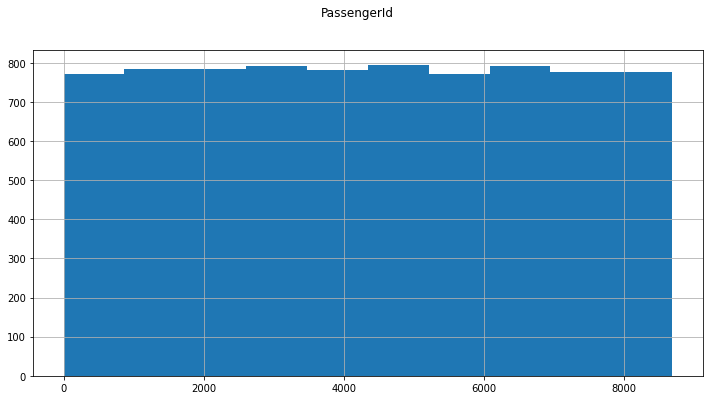

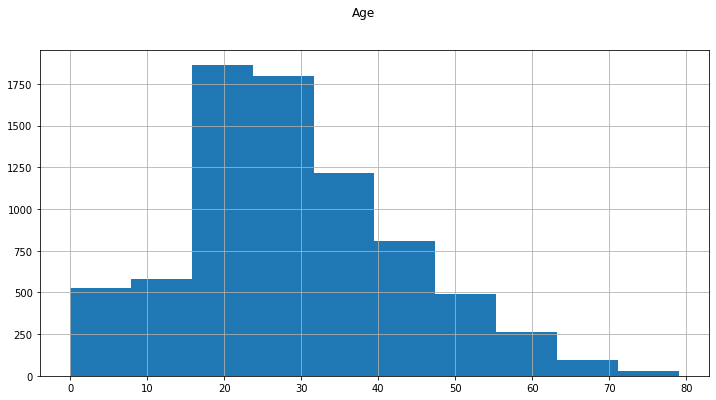

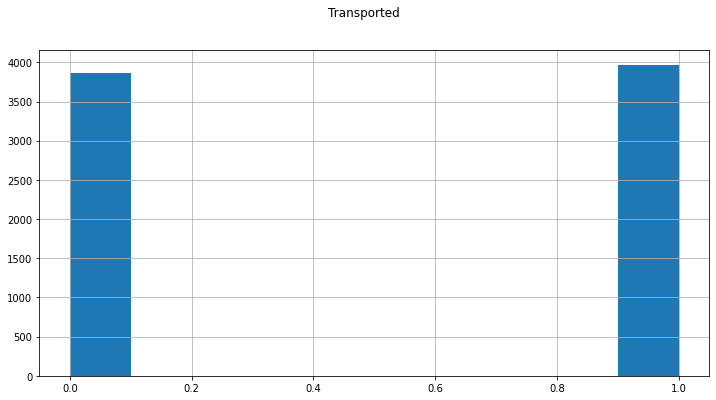

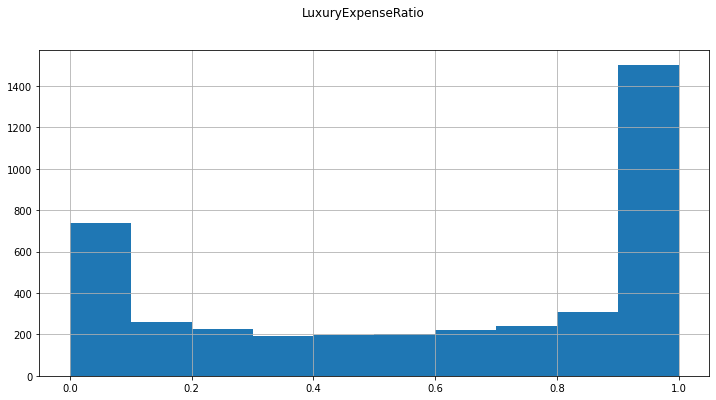

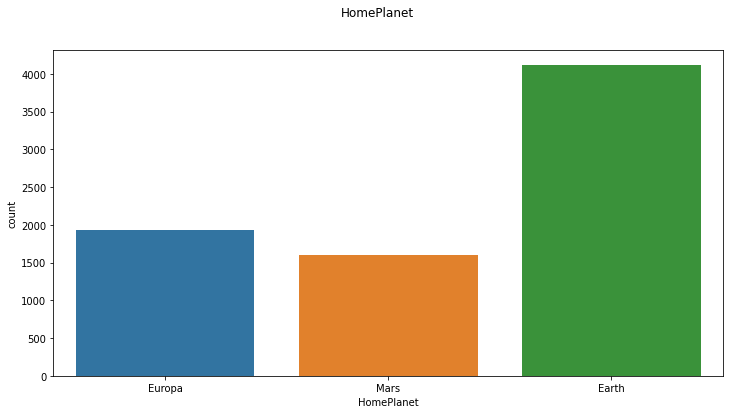

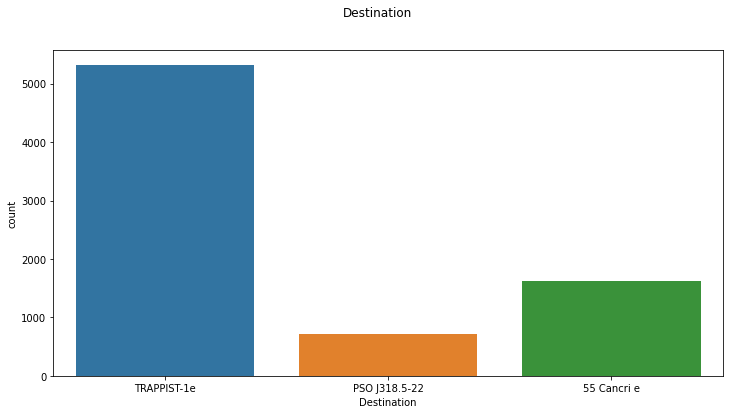

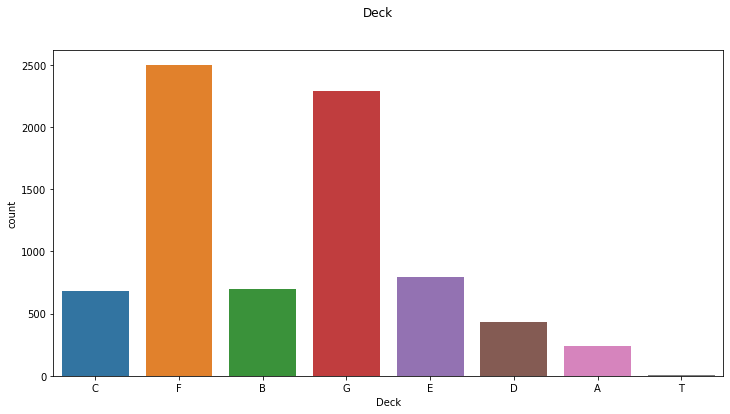

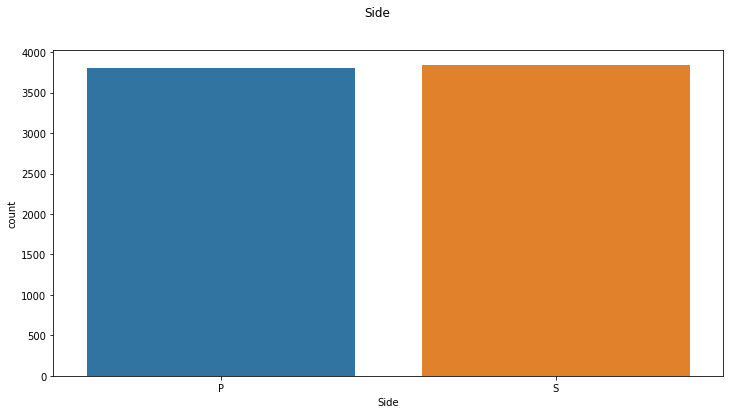

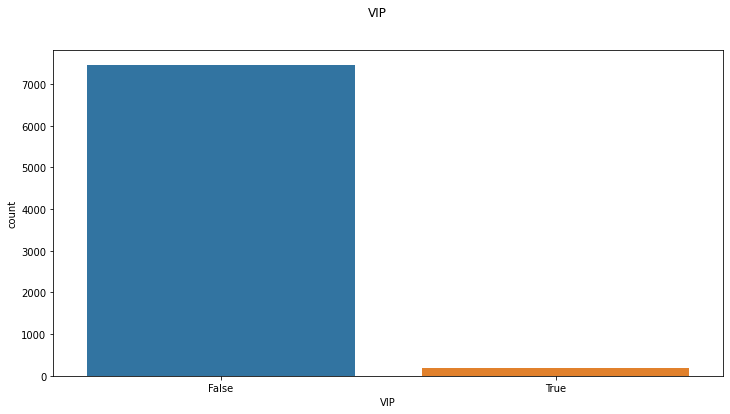

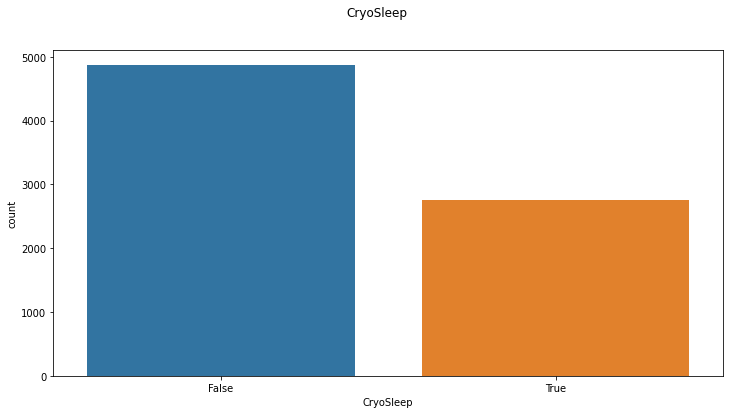

In [321]:
plot_histograms(df_train_explore)

## Diagramas de dispersión
El objetivo es explorar gráficamente correlaciones entre variables numéricas aperturadas por la variable objetivo

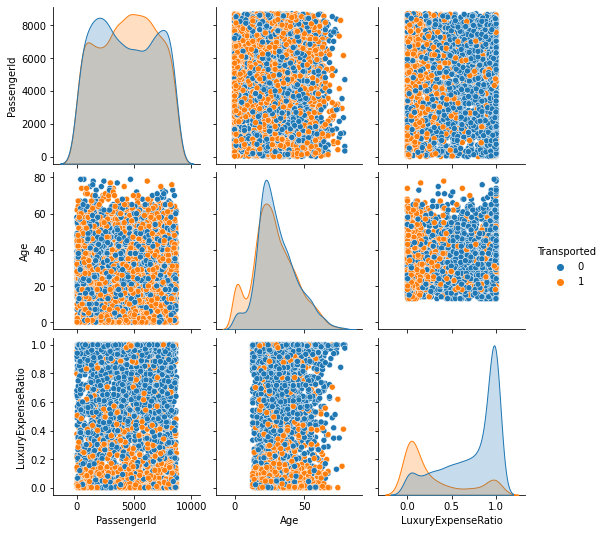

In [322]:
sns.pairplot(df_train_explore[numerical_columns], hue='Transported')

## Tablas de contingencia

In [323]:
for col in categorical_columns_low_cardinality:
  print(f"Tabla de contingencia {col}-Transported")
  print(pd.crosstab(df_train_explore[col], df_train_explore["Transported"]))
  print("\n")

Tabla de contingencia HomePlanet-Transported
Transported     0     1
HomePlanet             
Earth        2352  1762
Europa        653  1282
Mars          768   827


Tabla de contingencia Destination-Transported
Transported       0     1
Destination              
55 Cancri e     621  1004
PSO J318.5-22   355   367
TRAPPIST-1e    2803  2513


Tabla de contingencia Deck-Transported
Transported     0     1
Deck                   
A             115   122
B             186   512
C             214   466
D             246   189
E             506   286
F            1390  1109
G            1109  1185
T               3     1


Tabla de contingencia Side-Transported
Transported     0     1
Side                   
P            2075  1725
S            1694  2145


Tabla de contingencia VIP-Transported
Transported     0     1
VIP                    
False        3653  3803
True          116    67


Tabla de contingencia CryoSleep-Transported
Transported     0     1
CryoSleep              
False    

## Valores faltantes

<AxesSubplot:>

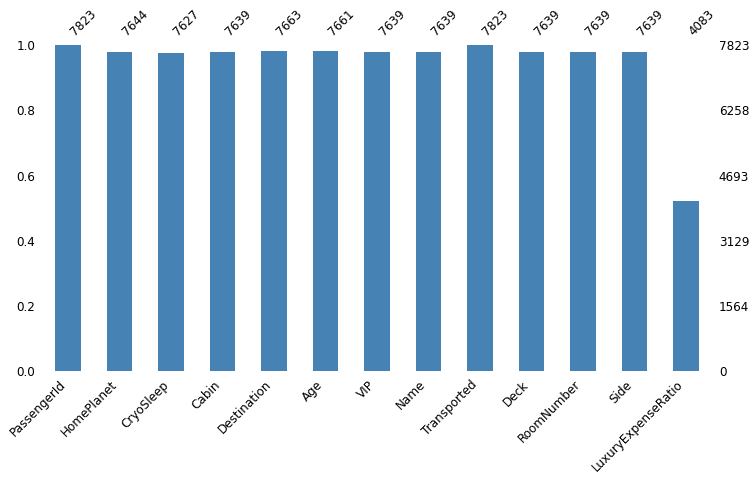

In [324]:
msno.bar(df_train_explore,figsize=(12, 6), fontsize=12, color='steelblue')

# Transformaciones

In [325]:
def map_encoder_results_to_column_names(categories, categorical_columns):
  # categories is the output from encoder.categories_

  column_names = [] 

  for i, group in enumerate(categories):
    categorical_col = categorical_columns[i]
    for value in group:
      column_names.append(f"{categorical_col}={value}")

  return column_names


def transform_array_to_dataframe(array, categories, cat_cols, num_cols):
  """ 
    array: NumPy array with categorical & numerical columns
    categories: list of arrays of categories (e.g. output encoder.categories_)
    cat_cols: column names of categorical variables
    num_cols: column names of numerical variables
  """
  
  new_cat_columns = map_encoder_results_to_column_names(categories, cat_cols)
  new_col_names = new_cat_columns + num_cols

  return pd.DataFrame(array, columns=new_col_names)


Separamos X e y. Removemos PassengerId dado que está correlacionada con la variable RoomNumber

In [326]:
PassengerId = df_train_explore.PassengerId

y = df_train_explore['Transported']

X = df_train_explore.drop(['Transported', 'PassengerId'], axis=1)
num_cols = [x for x in X if X[x].dtype != 'object']

X[:3]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Name,Deck,RoomNumber,Side,LuxuryExpenseRatio
0,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,Azhah Tronsive,C,123,P,0.512404
1,Mars,True,F/126/S,NaN,18.0,False,Roswal Sha,F,126,S,NaN
2,Europa,True,B/343/S,TRAPPIST-1e,33.0,NaN,Shaiam Tinganking,B,343,S,NaN


## Imputación de variables categóricas

In [327]:
from sklearn.impute import SimpleImputer

def impute_categorical_columns(X):
    simple_imputer = SimpleImputer(strategy='most_frequent', missing_values=np.NaN)
    X[categorical_columns_low_cardinality] = simple_imputer.fit_transform(X[categorical_columns_low_cardinality])

In [328]:
impute_categorical_columns(X)

In [329]:
X[:3]

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,Name,Deck,RoomNumber,Side,LuxuryExpenseRatio
0,Europa,False,C/123/P,TRAPPIST-1e,57.0,False,Azhah Tronsive,C,123,P,0.512404
1,Mars,True,F/126/S,TRAPPIST-1e,18.0,False,Roswal Sha,F,126,S,NaN
2,Europa,True,B/343/S,TRAPPIST-1e,33.0,False,Shaiam Tinganking,B,343,S,NaN


## Encoding de variables categóricas

In [330]:
from sklearn.preprocessing import OneHotEncoder # Ver si LabelEncoder puede resultar mejor

def encode_categorical_columns(X):
    cat_dict = [X[k].unique().tolist() for k in not_ordinal_columns]
    print(cat_dict)

    # We use one-hot encoding to avoid order or hierarchy confusions in the model
    encoder = OneHotEncoder(sparse=False, categories=cat_dict)
    cat_encoded = encoder.fit_transform(X[not_ordinal_columns])
    # We can inspect the categories found by the encoder 
    categories = encoder.categories_
    print(categories)
    print(cat_encoded)

    return cat_encoded, categories

In [331]:
from sklearn.preprocessing import  LabelEncoder

def get_matrix(X):
    for col in ordinal_columns:
        X[col] = X[col].astype(str)
        X[col] = LabelEncoder().fit_transform(X[col])

    ordinal_columns_matrix = X[ordinal_columns].values


    cat_encoded, categories = encode_categorical_columns(X)

    num_array = X[num_cols].values


    matrix = np.hstack((cat_encoded, ordinal_columns_matrix, num_array))

    return matrix, categories

X, categories = get_matrix(X)


[['Europa', 'Mars', 'Earth'], ['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e']]
[array(['Europa', 'Mars', 'Earth'], dtype=object), array(['TRAPPIST-1e', 'PSO J318.5-22', '55 Cancri e'], dtype=object)]
[[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0.]
 ...
 [0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [1. 0. 0. 0. 0. 1.]]


## Estandarización de las variables

In [332]:
from sklearn.preprocessing import StandardScaler

def standardize_matrix(X):
    # Habría que ver qué conviene, correr el scaler con las one-hot encoded variables,
    # o hacerlo solamente con las numéricas y dsp hacer el hstack

    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    print(X_scaled)

    return X_scaled

In [333]:
X = standardize_matrix(X)

[[ 1.74438931 -0.5060647  -1.10279069 ... -0.73750362  1.94463599
  -0.22096796]
 [-0.57326653  1.97603193 -1.10279069 ...  1.35592555 -0.7523468
          nan]
 [ 1.74438931 -0.5060647  -1.10279069 ...  1.35592555  0.28495427
          nan]
 ...
 [-0.57326653  1.97603193 -1.10279069 ...  1.35592555  1.80632918
          nan]
 [-0.57326653 -0.5060647   0.90679039 ... -0.73750362 -0.95980702
  -1.52287383]
 [ 1.74438931 -0.5060647  -1.10279069 ...  1.35592555  1.11479513
          nan]]


## Imputación de variables numéricas

In [334]:
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer 
from sklearn.neighbors import KNeighborsRegressor

def impute_numerical_columns(matrix, use_knn=False):

  if use_knn:
    imputer = IterativeImputer(random_state=0,  estimator=KNeighborsRegressor())
  else:
    imputer = IterativeImputer(random_state=0)

  return imputer.fit_transform(matrix)

In [335]:
X = impute_numerical_columns(X)

print(X)

# Para cada variable imputada ver la distribución

[[ 1.74438931 -0.5060647  -1.10279069 ... -0.73750362  1.94463599
  -0.22096796]
 [-0.57326653  1.97603193 -1.10279069 ...  1.35592555 -0.7523468
   0.12566781]
 [ 1.74438931 -0.5060647  -1.10279069 ...  1.35592555  0.28495427
  -0.18595612]
 ...
 [-0.57326653  1.97603193 -1.10279069 ...  1.35592555  1.80632918
   0.1584108 ]
 [-0.57326653 -0.5060647   0.90679039 ... -0.73750362 -0.95980702
  -1.52287383]
 [ 1.74438931 -0.5060647  -1.10279069 ...  1.35592555  1.11479513
  -0.20438735]]


# Predicciones 

Primero unimos los resultados de los pasos previos

In [336]:
X_df = transform_array_to_dataframe(X, categories, not_ordinal_columns, ordinal_columns+num_cols)

X_df

,HomePlanet=Europa,HomePlanet=Mars,HomePlanet=Earth,Destination=TRAPPIST-1e,Destination=PSO J318.5-22,Destination=55 Cancri e,Deck,Side,VIP,CryoSleep,Age,LuxuryExpenseRatio
0,1.744389,-0.506065,-1.102791,0.654674,-0.318866,-0.512036,-1.310594,-1.028924,-0.154767,-0.737504,1.944636,-0.220968
1,-0.573267,1.976032,-1.102791,0.654674,-0.318866,-0.512036,0.389513,0.971889,-0.154767,1.355926,-0.752347,0.125668
2,1.744389,-0.506065,-1.102791,0.654674,-0.318866,-0.512036,-1.877297,0.971889,-0.154767,1.355926,0.284954,-0.185956
3,-0.573267,-0.506065,0.906790,0.654674,-0.318866,-0.512036,0.389513,-1.028924,-0.154767,-0.737504,0.976488,-0.987607
4,-0.573267,-0.506065,0.906790,0.654674,-0.318866,-0.512036,0.956215,-1.028924,-0.154767,-0.737504,-0.683193,-1.445352
...,...,...,...,...,...,...,...,...,...,...,...,...
7818,-0.573267,1.976032,-1.102791,0.654674,-0.318866,-0.512036,0.389513,0.971889,-0.154767,-0.737504,-1.167267,0.124155
7819,-0.573267,-0.506065,0.906790,0.654674,-0.318866,-0.512036,0.956215,0.971889,-0.154767,-0.737504,1.045642,-1.364123
7820,-0.573267,1.976032,-1.102791,0.654674,-0.318866,-0.512036,0.389513,-1.028924,-0.154767,1.355926,1.806329,0.158411
7821,-0.573267,-0.506065,0.906790,0.654674,-0.318866,-0.512036,-0.177190,-1.028924,-0.154767,-0.737504,-0.959807,-1.522874


Funciones

In [337]:
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score
import itertools

def format_results(results, params):
  results_df = pd.DataFrame(results)
  cols = ['param_' + param for param in params.keys()] 
  cols += ['mean_test_score', 'std_test_score']
  results_df = results_df[cols].sort_values(by='mean_test_score', 
                                            ascending=False)
  results_df['variance'] = results_df['std_test_score']**2
  return results_df


def adjust_hyperparameters(X_train, y_train, estimator, params, cv=5,
                           print_values=False, print_results=True,
                           print_best=True):
    """
    This function searches for the best parameters given an estimator and 
    parameter grid values.
    """
    grid_cv = GridSearchCV(
        estimator=estimator,
        param_grid=params,
        cv=cv,
        scoring='accuracy',
        n_jobs=5, refit=True, return_train_score=True, verbose=1)

    # Fit to the training data
    grid_cv.fit(X_train, y_train)

    best_params = grid_cv.best_params_

    if print_values:
      # Print the values used for hyperparameters
      print(f"""
      The values used for the hyperparameters:
      {grid_cv.cv_results_}
      """)

    if print_best:
      # Print best score and params
      print("\nMejor configuración:")
      display(pd.DataFrame([best_params]))
      print("\nAccuracy promedio (mejor configuración) %.3f" % grid_cv.best_score_)

    if print_results:
      results = format_results(grid_cv.cv_results_, params)
      print("\nAccuracy promedio y varianza para todas las configuraciones "
      "(ordernadas en forma descendiente):")
      display(results)

    return best_params


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure().clear()
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Etiqueta correcta')
    plt.xlabel('Etiqueta predicha')


def report_metrics(y_true, y_predicted, cm_labels, description=None):
  """Prints values of selected metrics for a pair of true and predicted targets.
  """
  if description:
    print(description)

  print("\tAccuracy (exactitud):  %.2f" % accuracy_score(y_true, y_predicted))
  print("\tPrecision (precisión):  %.2f" % precision_score(y_true, y_predicted))
  print("\tRecall (cobertura/exhaustividad):  %.2f" % 
        recall_score(y_true, y_predicted))
  print("\tF1:  %.2f" % f1_score(y_true, y_predicted))

  cm = confusion_matrix(y_true, y_predicted)
  
  plot_confusion_matrix(cm, cm_labels, 
                        title=f"Confusion matrix ({description})")
  

def evaluate_model(model, best_params, X_train, y_train, X_test, y_test):
  pred_classes = [1, 0]

  model.set_params(**best_params)

  model.fit(X_train, y_train)

  y_pred_test = model.predict(X_test)
  y_pred_train = model.predict(X_train)

  report_metrics(y_train, y_pred_train, pred_classes,
                description="Conjunto de entrenamiento")

  report_metrics(y_test, y_pred_test, pred_classes, 
                description="Conjunto de evaluación")

Dividimos el conjunto entre entrenamiento y evaluación

In [338]:
X_train, X_test, y_train, y_test = train_test_split(X_df, y, test_size=0.2, random_state=0)

## Modelo 1

In [339]:
from sklearn.ensemble import RandomForestClassifier


parameter_grid = {
    'criterion': ['gini', 'entropy'], # log_loss tira error
    'max_depth': np.arange(4, 25, 4),
    'n_estimators': np.arange(10, 100, 10),
    'max_features': ['log2', 'sqrt']
}

random_forest_model = RandomForestClassifier(random_state=42)

random_forest_best_params = adjust_hyperparameters(X_train, y_train, random_forest_model, parameter_grid)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

Mejor configuración:


,criterion,max_depth,max_features,n_estimators
0,entropy,8,log2,90



Accuracy promedio (mejor configuración) 0.797

Accuracy promedio y varianza para todas las configuraciones (ordernadas en forma descendiente):


,param_criterion,param_max_depth,param_n_estimators,param_max_features,mean_test_score,std_test_score,variance
134,entropy,8,90,log2,0.797062,0.009061,0.000082
143,entropy,8,90,sqrt,0.797062,0.009061,0.000082
142,entropy,8,80,sqrt,0.796103,0.008543,0.000073
133,entropy,8,80,log2,0.796103,0.008543,0.000073
132,entropy,8,70,log2,0.795944,0.009061,0.000082
...,...,...,...,...,...,...,...
118,entropy,4,20,sqrt,0.748328,0.018165,0.000330
108,entropy,4,10,log2,0.745288,0.012927,0.000167
117,entropy,4,10,sqrt,0.745288,0.012927,0.000167
9,gini,4,10,sqrt,0.741773,0.015156,0.000230


Conjunto de entrenamiento
	Accuracy (exactitud):  0.82
	Precision (precisión):  0.84
	Recall (cobertura/exhaustividad):  0.81
	F1:  0.82
Conjunto de evaluación
	Accuracy (exactitud):  0.81
	Precision (precisión):  0.82
	Recall (cobertura/exhaustividad):  0.80
	F1:  0.81


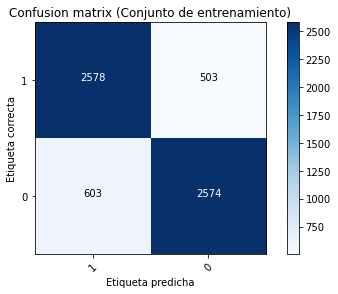

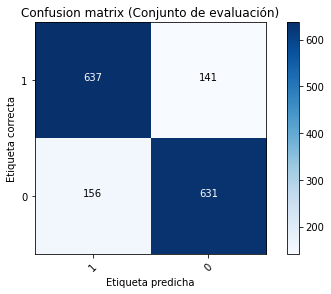

In [340]:
# Evaluamos para la mejor configuración encontrada:

evaluate_model(random_forest_model, random_forest_best_params, X_train, y_train, X_test, y_test)

## Modelo 2

In [341]:
import xgboost as xgb

parameter_grid = {
    "learning_rate": np.linspace(0.1, 0.2, 3), 
    'max_depth': np.arange(4, 25, 4),
    'n_estimators': np.arange(10, 100, 10),
}

xgboost_model = xgb.XGBClassifier()

xgboost_best_params = adjust_hyperparameters(X_train, y_train, xgboost_model, parameter_grid)



Fitting 5 folds for each of 162 candidates, totalling 810 fits

Mejor configuración:


,learning_rate,max_depth,n_estimators
0,0.15,4,80



Accuracy promedio (mejor configuración) 0.797

Accuracy promedio y varianza para todas las configuraciones (ordernadas en forma descendiente):


,param_learning_rate,param_max_depth,param_n_estimators,mean_test_score,std_test_score,variance
61,0.15,4,80,0.796742,0.011095,0.000123
111,0.2,4,40,0.796582,0.010223,0.000105
60,0.15,4,70,0.796262,0.010240,0.000105
59,0.15,4,60,0.796262,0.009300,0.000086
62,0.15,4,90,0.795943,0.011232,0.000126
...,...,...,...,...,...,...
157,0.2,24,50,0.759991,0.010382,0.000108
151,0.2,20,80,0.759832,0.013588,0.000185
159,0.2,24,70,0.759511,0.010541,0.000111
160,0.2,24,80,0.759033,0.013238,0.000175


Conjunto de entrenamiento
	Accuracy (exactitud):  0.82
	Precision (precisión):  0.83
	Recall (cobertura/exhaustividad):  0.82
	F1:  0.82
Conjunto de evaluación
	Accuracy (exactitud):  0.81
	Precision (precisión):  0.82
	Recall (cobertura/exhaustividad):  0.80
	F1:  0.81


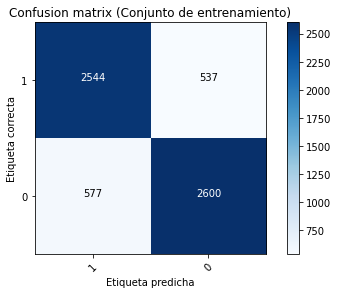

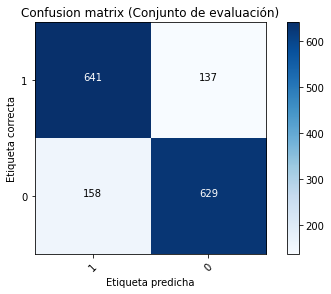

In [342]:
# Evaluamos para la mejor configuración encontrada:

evaluate_model(xgboost_model, xgboost_best_params, X_train, y_train, X_test, y_test)

## Modelo 3

In [343]:
from sklearn.svm import SVC

svc_model = SVC(gamma='auto')

param_grid = {
    "C": np.arange(1, 5, 0.2), 
    "kernel": ["rbf"],
}

svc_best_params = adjust_hyperparameters(X_train, y_train, svc_model, param_grid)


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Mejor configuración:


,C,kernel
0,1.4,rbf



Accuracy promedio (mejor configuración) 0.789

Accuracy promedio y varianza para todas las configuraciones (ordernadas en forma descendiente):


,param_C,param_kernel,mean_test_score,std_test_score,variance
2,1.4,rbf,0.789233,0.010054,0.000101
4,1.8,rbf,0.789073,0.009806,0.000096
1,1.2,rbf,0.789072,0.007444,0.000055
3,1.6,rbf,0.788913,0.009737,0.000095
0,1.0,rbf,0.788913,0.007255,0.000053
16,4.2,rbf,0.788754,0.010076,0.000102
5,2.0,rbf,0.788753,0.009048,0.000082
12,3.4,rbf,0.788594,0.010288,0.000106
15,4.0,rbf,0.788594,0.010189,0.000104
14,3.8,rbf,0.788594,0.010189,0.000104


Conjunto de entrenamiento
	Accuracy (exactitud):  0.79
	Precision (precisión):  0.79
	Recall (cobertura/exhaustividad):  0.81
	F1:  0.80
Conjunto de evaluación
	Accuracy (exactitud):  0.80
	Precision (precisión):  0.81
	Recall (cobertura/exhaustividad):  0.80
	F1:  0.80


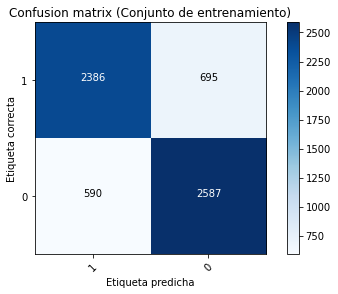

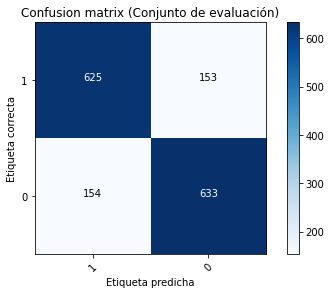

In [344]:
evaluate_model(svc_model, svc_best_params, X_train, y_train, X_test, y_test)

# Predicciones de Test

## Transformaciones

In [347]:
split_cabin(df_test)
add_luxury_expenses(df_test)

PassengerId = df_test.PassengerId
X_test = df_test.drop(['PassengerId'], axis=1)
num_cols = [x for x in X_test if X_test[x].dtype != 'object']

impute_categorical_columns(X_test)

X_test, categories_test = get_matrix(X_test)

X_test = standardize_matrix(X_test)

X_test = impute_numerical_columns(X_test)

X_test_df = transform_array_to_dataframe(X_test, categories_test, not_ordinal_columns, ordinal_columns+num_cols)

[['Europa', 'Earth', 'Mars'], ['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e']]
[array(['Europa', 'Earth', 'Mars'], dtype=object), array(['55 Cancri e', 'PSO J318.5-22', 'TRAPPIST-1e'], dtype=object)]
[[1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 ...
 [0. 1. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0. 1.]]
[[ 1.85439357 -1.19023807 -0.48196952 ...  1.44778638  0.38262041
          nan]
 [-0.53925985  0.84016805 -0.48196952 ...  1.44778638 -1.0434885
          nan]
 [-0.53925985  0.84016805 -0.48196952 ... -0.69070963  1.06171989
   1.04597858]
 ...
 [-0.53925985  0.84016805 -0.48196952 ...  1.44778638 -0.70393876
          nan]
 [-0.53925985  0.84016805 -0.48196952 ... -0.69070963 -0.70393876
   1.00472608]
 [-0.53925985  0.84016805 -0.48196952 ... -0.69070963 -0.56811886
   1.04896328]]


## Predicción

In [348]:
test_id = PassengerId
test_pred_random_forest = random_forest_model.predict(X_test_df)
test_pred_xgboost = xgboost_model.predict(X_test_df)
test_pred_svc = svc_model.predict(X_test_df)


C:\Users\Joaquin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)
C:\Users\Joaquin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


## Generación de salida .csv

In [ ]:
def get_predictions(test_id, test_pred):
    return pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])

test_pred_random_forest_predictions = get_predictions(test_id, test_pred_random_forest)
test_pred_xgboost_prediction = get_predictions(test_id, test_pred_xgboost)
test_pred_svc_prediction = get_predictions(test_id, test_pred_svc)

voting = pd.DataFrame()

voting["Transported"] =  test_pred_random_forest_predictions["Transported"] + test_pred_xgboost_prediction["Transported"] + test_pred_svc_prediction["Transported"] 


voting["PassengerId"] = test_pred_random_forest_predictions["PassengerId"]
voting["Transported"] = voting["Transported"].apply(lambda x: 1 if x>=2 else 0) 


In [ ]:
voting.to_csv(f"predicciones_grupo_29_voting.csv", header=True, index=False)

In [350]:
def generate_output(test_id, test_pred, extension):
    output_df = pd.DataFrame(list(zip(test_id, test_pred)), columns=["PassengerId", "Transported"])
    output_df.to_csv(f"predicciones_grupo_29_{extension}.csv", header=True, index=False)

In [351]:
generate_output(test_id, test_pred_random_forest, "random_forest")
generate_output(test_id, test_pred_xgboost, "xgboost")
generate_output(test_id, test_pred_svc, "svc")